# Initial Conditions Optimization
## Plot History

In [118]:
%matplotlib inline
import matplotlib
matplotlib.font_manager._rebuild()
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import matplotlib.style as style
style.use('fivethirtyeight')
import ray
import io
import os
from IPython.display import display, HTML, Markdown

## Load PlayFair Display and Roboto Fonts from Google

In [119]:
from tempfile import NamedTemporaryFile
import urllib.request
import matplotlib.font_manager as fm

github_url = 'https://github.com/google/fonts/blob/master/ofl/playfairdisplay/static/PlayfairDisplay-Regular.ttf'
url = github_url + '?raw=true'  # You want the actual file, not some html

request = urllib.request.Request(url)
response = urllib.request.urlopen(request)
f = NamedTemporaryFile(delete=False, suffix='.ttf')
f.write(response.read())
f.close()
heading_font = fm.FontProperties(fname=f.name, size=28)

github_url = 'https://github.com/google/fonts/blob/master/ofl/roboto/static/Roboto-Regular.ttf'
url = github_url + '?raw=true'  # You want the actual file, not some html

request = urllib.request.Request(url)
response = urllib.request.urlopen(request)
f = NamedTemporaryFile(delete=False, suffix='.ttf')
f.write(response.read())
f.close()
subtitle_font = fm.FontProperties(fname=f.name, size=20)


## Load Humor Sans Font

In [120]:
github_url = 'http://antiyawn.com/uploads/Humor-Sans-1.0.ttf'
# github_url = 'https://github.com/ipython/xkcd-font/blob/master/xkcd-script/font/xkcd-script.ttf'
# github_url = 'https://github.com/ipython/xkcd-font/blob/master/xkcd/build/xkcd-Regular.otf'

url = github_url + '?raw=true'  # You want the actual file, not some html

request = urllib.request.Request(url)
response = urllib.request.urlopen(request)
f = NamedTemporaryFile(delete=False, suffix='.ttf')
f.write(response.read())
f.close()
comic_font = fm.FontProperties(fname=f.name, size=18)

# Main code

In [121]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines){
    return false;}

<IPython.core.display.Javascript object>

## Load Initial Parameters

In [122]:
dfparam = pd.read_csv("data/param.csv")
display(dfparam)


DRS  start-date  prediction-range         s0  \
0        DRS 01 - Grande São Paulo  2020-03-20               200  2000000.0   
1               DRS 02 - Araçatuba  2020-04-01               200      500.0   
2              DRS 03 - Araraquara  2020-04-01               200     2000.0   
3        DRS 04 - Baixada Santista  2020-04-01               200     8000.0   
4                DRS 05 - Barretos  2020-04-01               200     2000.0   
5                   DRS 06 - Bauru  2020-04-01               200    10000.0   
6                DRS 07 - Campinas  2020-04-01               200    20000.0   
7                  DRS 08 - Franca  2020-04-01               200     1000.0   
8                 DRS 09 - Marília  2020-04-01               200     5000.0   
9              DRS 10 - Piracicaba  2020-04-01               200    10000.0   
10    DRS 11 - Presidente Prudente  2020-04-01               200     1000.0   
11               DRS 12 - Registro  2020-04-01               200     1000.0   
12         DRS 13 - Ribeirão Preto  2020-04-01               200     5000.0   
13  DRS 14 - São João da Boa Vista  2020-04-01               200     2000.0   
14  DRS 15 - São José do Rio Preto  2020-04-01               200    10000.0   
15               DRS 16 - Sorocaba  2020-04-01               200     1200.0   
16                DRS 17 - Taubaté  2020-04-01               200    10000.0   

        e0      a0        i0        r0        d0  START  RATIO  WCASES  WREC  
0   0.0001  0.0001  800.0000  300.0000  400.0000      0   0.15    0.15  0.05  
1   0.0001  0.0001    0.0001    0.0001    0.0001      0   0.15    0.40  0.10  
2   0.0001  0.0001    0.0001    0.0001    0.0001      0   0.15    0.40  0.10  
3   0.0001  0.0001    0.0001    0.0001    0.0001      0   0.15    0.40  0.10  
4   0.0001  0.0001    0.0001    0.0001    0.0001      0   0.15    0.40  0.10  
5   0.0001  0.0001    4.0000    0.0001    0.0001      0   0.15    0.40  0.10  
6   0.0001  0.0001   40.0000    0.0001    0.0001      0   0.15    0.40  0.10  
7   0.0001  0.0001    0.0001    0.0001    0.0001      0   0.15    0.40  0.10  
8   0.0001  0.0001    0.0001    0.0001    0.0001      0   0.15    0.40  0.10  
9   0.0001  0.0001    0.0001    0.0001    1.0000      0   0.15    0.40  0.10  
10  0.0001  0.0001    0.0001    0.0001    0.0001      0   0.15    0.40  0.10  
11  0.0001  0.0001    0.0001    0.0001    0.0001      0   0.15    0.40  0.10  
12  0.0001  0.0001    0.0001    0.0001    0.0001      5   0.15    0.40  0.10  
13  0.0001  0.0001    0.0001    0.0001    0.0001      0   0.15    0.40  0.10  
14  0.0001  0.0001    0.0001    0.0001    0.0001      0   0.15    0.40  0.10  
15  0.0001  0.0001    2.0000    0.0001    0.0001      0   0.15    0.40  0.10  
16  0.0001  0.0001   17.0000    0.0001    2.0000      0   0.15    0.40  0.10

## Select data set

In [123]:
opt=2

#select history file version, model and states
if opt==0:
    #original s0,i0,d0 based on param.csv file
    version=105
    model="Yabox"
    DRS=dfparam.DRS

if opt==1:
    #introduced s0 based on population
    #SP went too high on s0 and wcases
    version=106
    model="Yabox"
    DRS=dfparam.DRS

if opt==2:
    #improved range for s0,i0,d0 and weights
    #increased delta startdate +-3
    version=107
    model="Yabox"
    DRS=dfparam.DRS

In [124]:
strFile="results/IC_optimizeddistrictRegions"+str(version)+".csv"
if os.path.isfile(strFile):
    os.remove(strFile)

## Plot and Save Results

# Results for DRS 01 - Grande São Paulo District Region

gtot  startdate  startNcases       s0   i0   d0  wcases    wrec
1016  32985761 2020-03-18          117  7840120  136  196   0.495  0.0081

## 5 Lowest Results

gtot  startdate  startNcases       s0   i0   d0  wcases    wrec
1016   32985761 2020-03-18          117  7840120  136  196  0.4950  0.0081
1239   39496096 2020-03-19           88  8568050  644   31  0.3971  0.0199
3529   58510128 2020-03-21          190  6466416   45  174  0.3724  0.0109
1528   72818497 2020-03-21          141  8296245  281   28  0.4507  0.0045
1248  106676419 2020-03-19          113  8057389  592  157  0.5174  0.0119

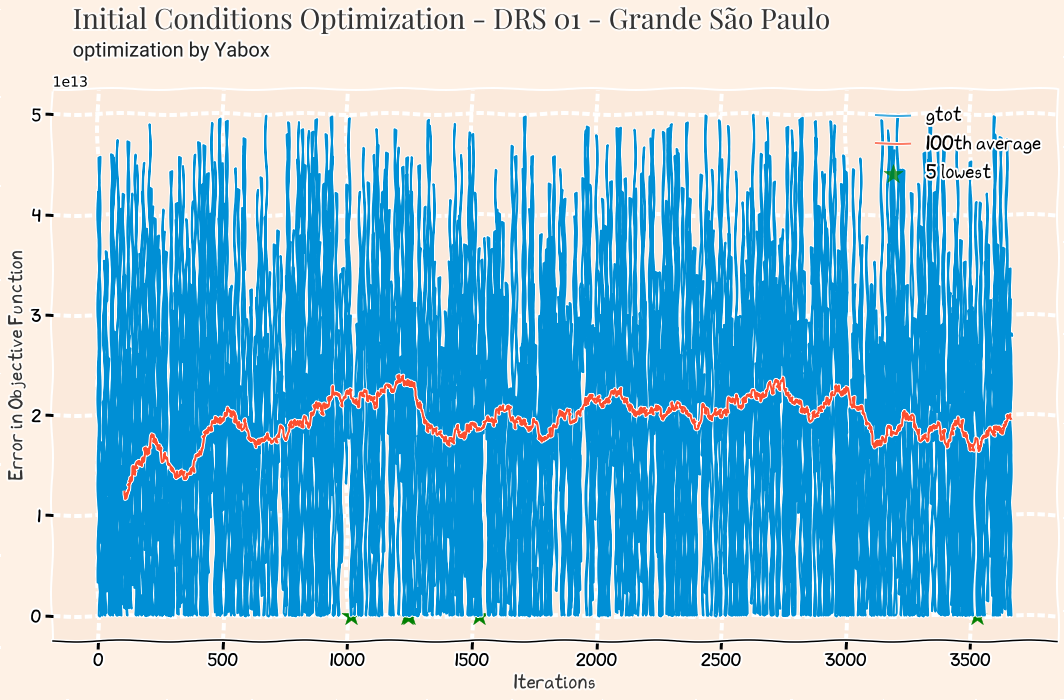

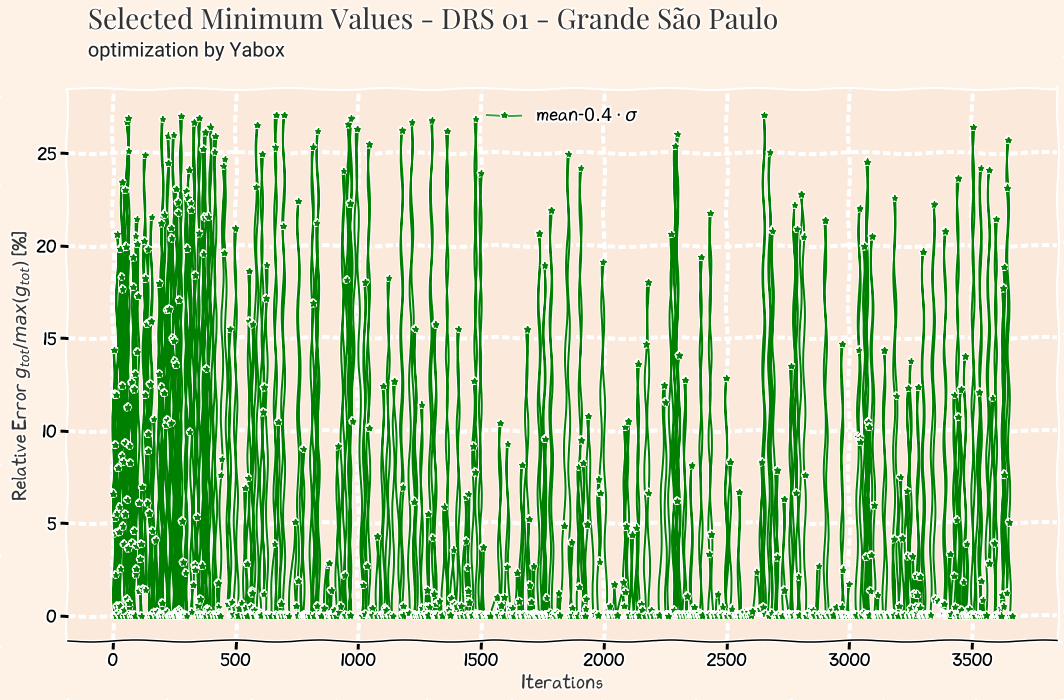

# Results for DRS 02 - Araçatuba District Region

gtot  startdate  startNcases      s0   i0   d0  wcases    wrec
4147  26469 2020-03-30          212  278378  615  168  0.6135  0.0309

## 5 Lowest Results

gtot  startdate  startNcases      s0   i0   d0  wcases    wrec
4147  26469 2020-03-30          212  278378  615  168  0.6135  0.0309
2714  32896 2020-03-29            5  282699  182   51  0.6257  0.0362
2514  34206 2020-03-29           32  307969  140   57  0.6107  0.0432
2291  38671 2020-03-30            9  314174  124   71  0.5697  0.0094
3039  40017 2020-04-03           32  284376   47   54  0.5459  0.0121

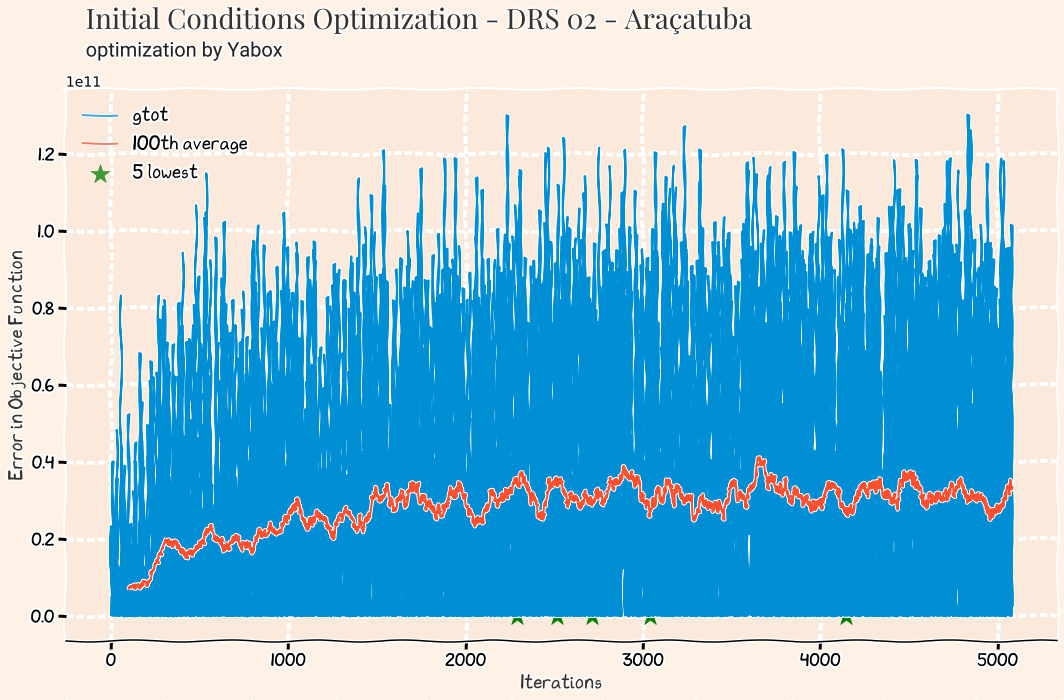

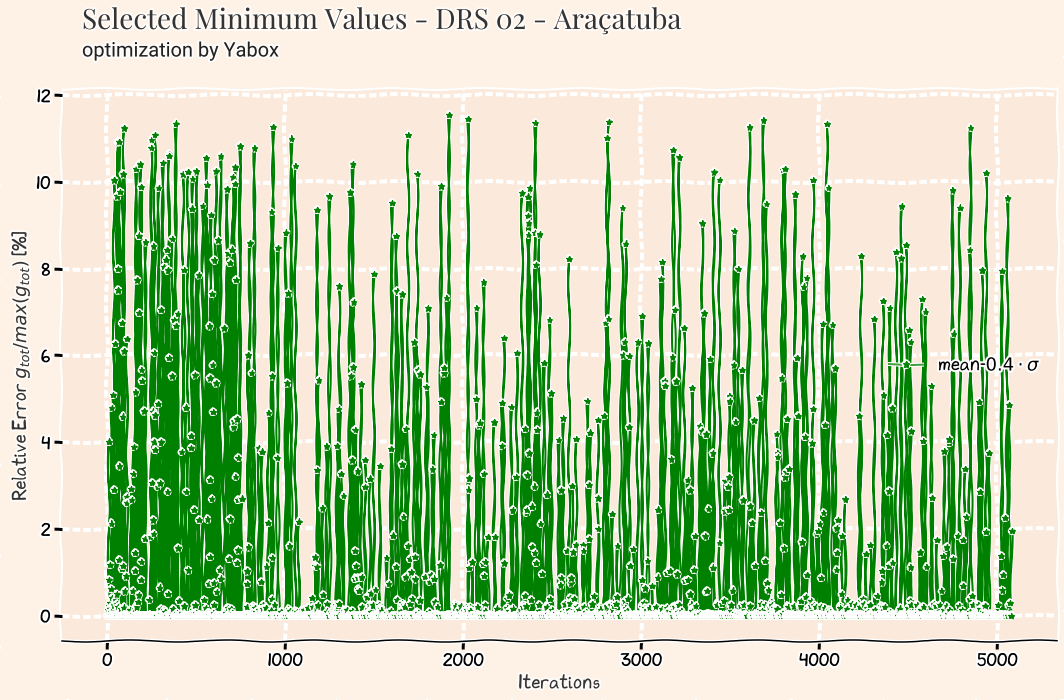

# Results for DRS 03 - Araraquara District Region

gtot  startdate  startNcases      s0   i0   d0  wcases    wrec
2715  26950 2020-03-30           93  377711  534  102  0.5056  0.0034

## 5 Lowest Results

gtot  startdate  startNcases      s0   i0   d0  wcases    wrec
2715  26950 2020-03-30           93  377711  534  102  0.5056  0.0034
4018  40438 2020-04-01          135  133715  951  124  0.3641  0.0156
2614  62115 2020-04-02          154  409008   57  122  0.3919  0.0104
3871  69670 2020-04-02           94  377792  150  100  0.4015  0.0428
2292  71813 2020-03-29           42  402902   99  139  0.5371  0.0167

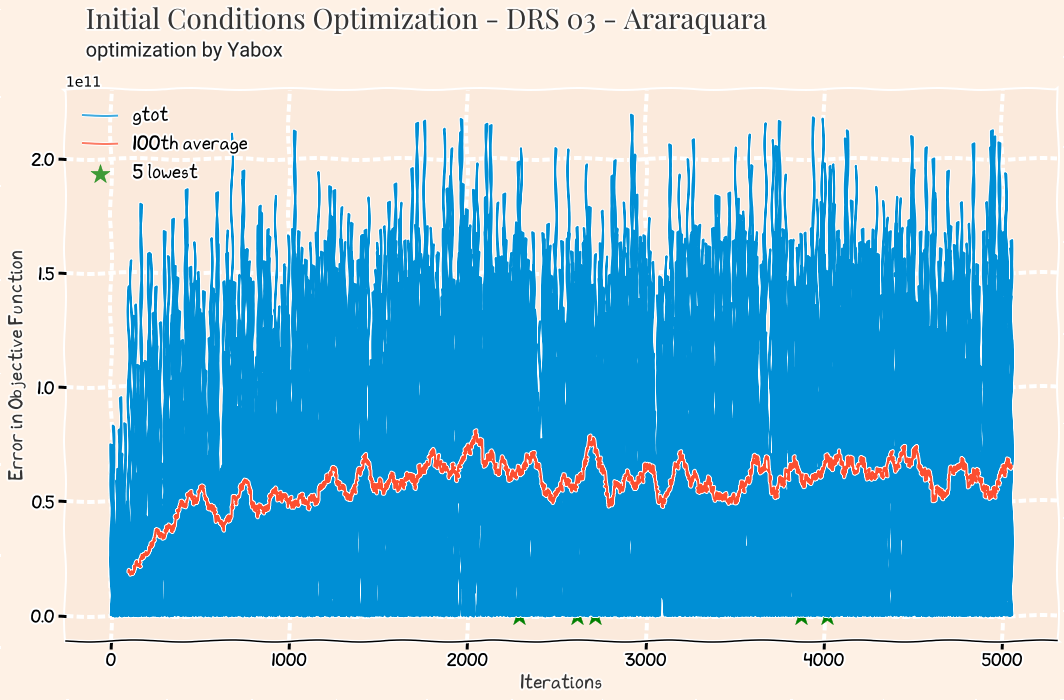

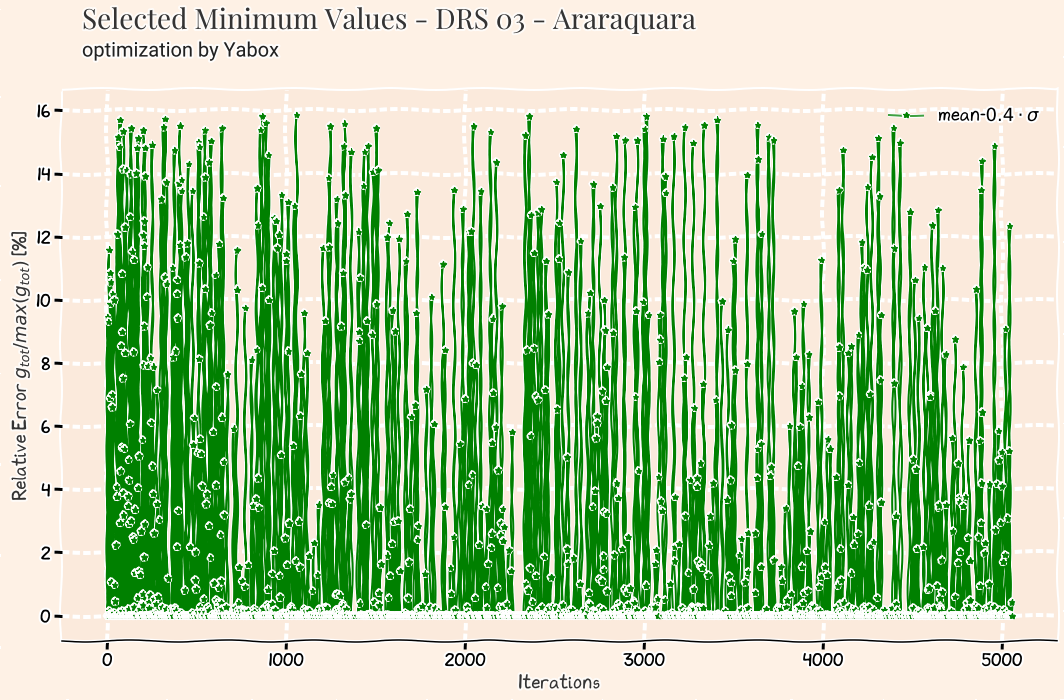

# Results for DRS 04 - Baixada Santista District Region

gtot  startdate  startNcases      s0   i0   d0  wcases    wrec
1526  1454767 2020-04-01          155  718013  270  281  0.4062  0.0124

## 5 Lowest Results

gtot  startdate  startNcases      s0   i0   d0  wcases    wrec
1526  1454767 2020-04-01          155  718013  270  281  0.4062  0.0124
273   1541123 2020-04-01           71  164408   24  175  0.5567  0.0020
203   3293002 2020-04-03          124  422347  187  116  0.4668  0.0020
2419  3306810 2020-03-30          197  454862  222  267  0.4776  0.0050
2146  3614711 2020-03-31          218  270776  765  116  0.6176  0.0348

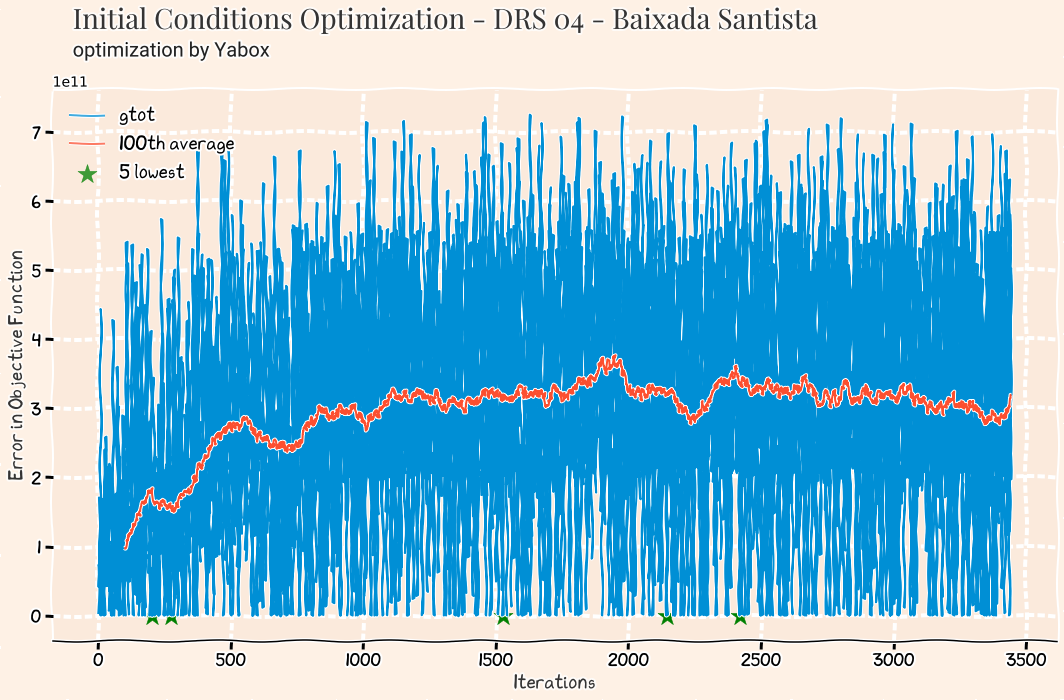

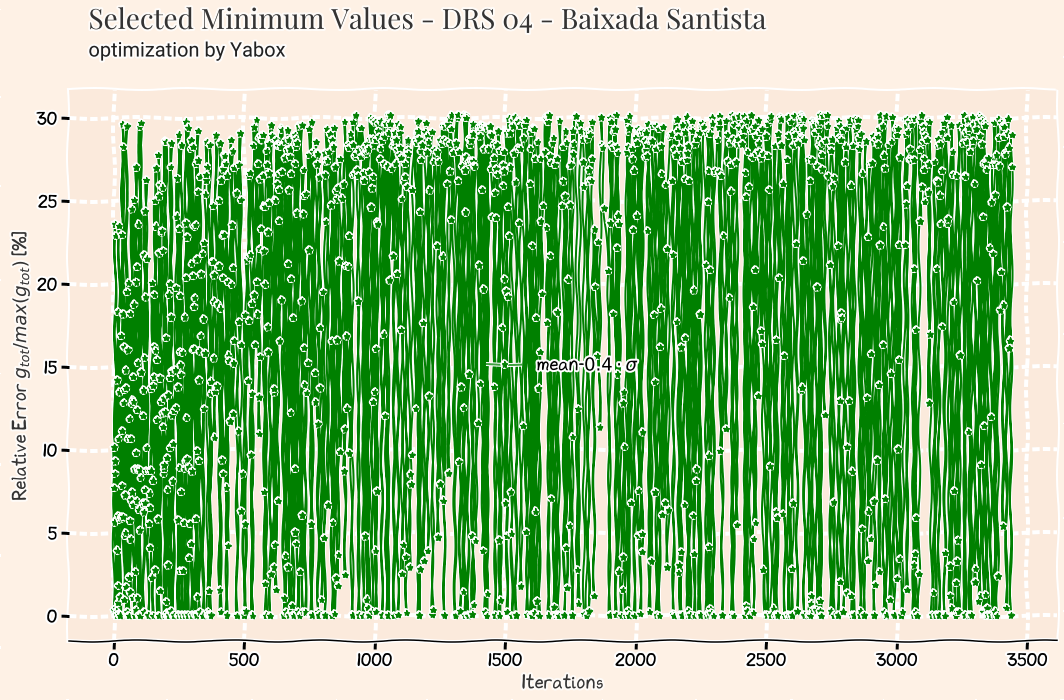

# Results for DRS 05 - Barretos District Region

gtot  startdate  startNcases      s0   i0  d0  wcases    wrec
776  2136 2020-04-03          105  147064  883  14  0.3535  0.0211

## 5 Lowest Results

gtot  startdate  startNcases      s0   i0   d0  wcases    wrec
776    2136 2020-04-03          105  147064  883   14  0.3535  0.0211
5098  10532 2020-03-29           91  168614    8   32  0.6003  0.0063
4269  19571 2020-03-29          202  171075  125   20  0.6114  0.0305
984   30869 2020-03-30           68  163130  241  160  0.3639  0.0215
1512  35111 2020-04-01            7  174936   81   38  0.5084  0.0295

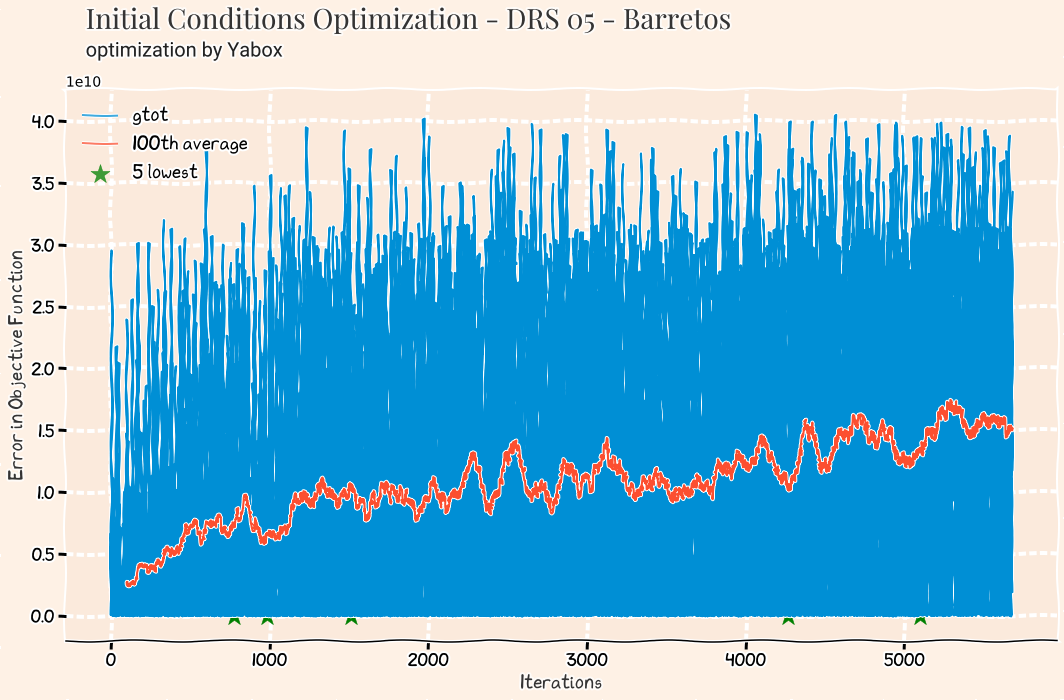

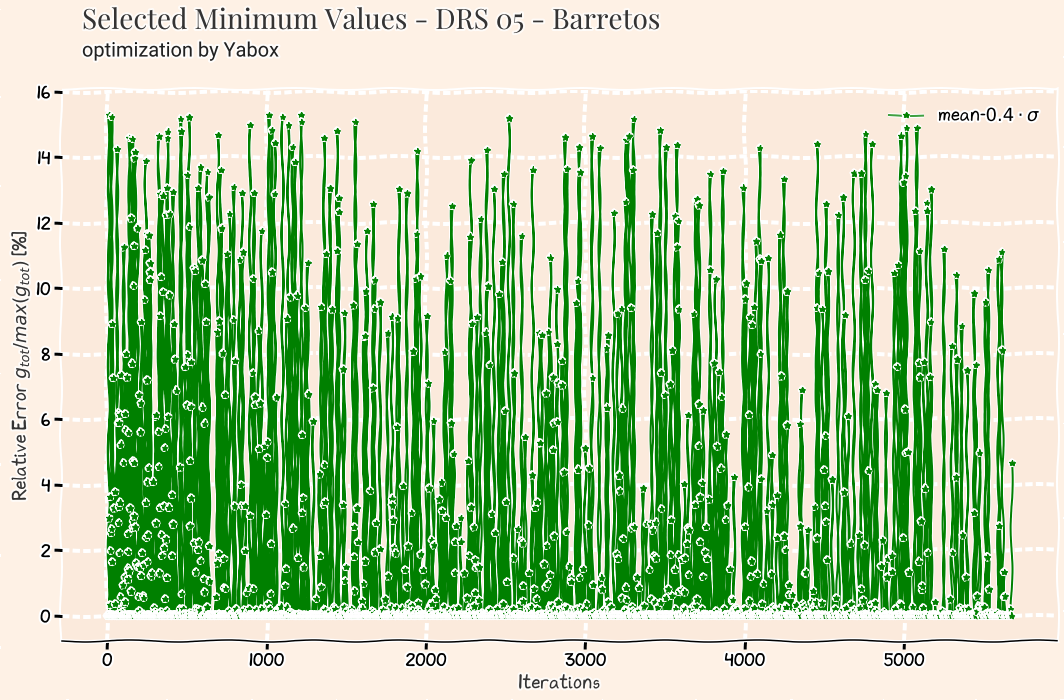

# Results for DRS 06 - Bauru District Region

gtot  startdate  startNcases      s0   i0   d0  wcases    wrec
1122  177999 2020-04-01           59  717995  263  201  0.5443  0.0304

## 5 Lowest Results

gtot  startdate  startNcases      s0   i0   d0  wcases    wrec
1122  177999 2020-04-01           59  717995  263  201  0.5443  0.0304
2998  210189 2020-04-01          163  716700  443   37  0.5152  0.0443
1160  303845 2020-03-29          139  615693  589   84  0.3744  0.0456
1298  372086 2020-04-01          145  612578  165   22  0.5621  0.0027
1679  378976 2020-04-01           71  683606  103   17  0.5866  0.0176

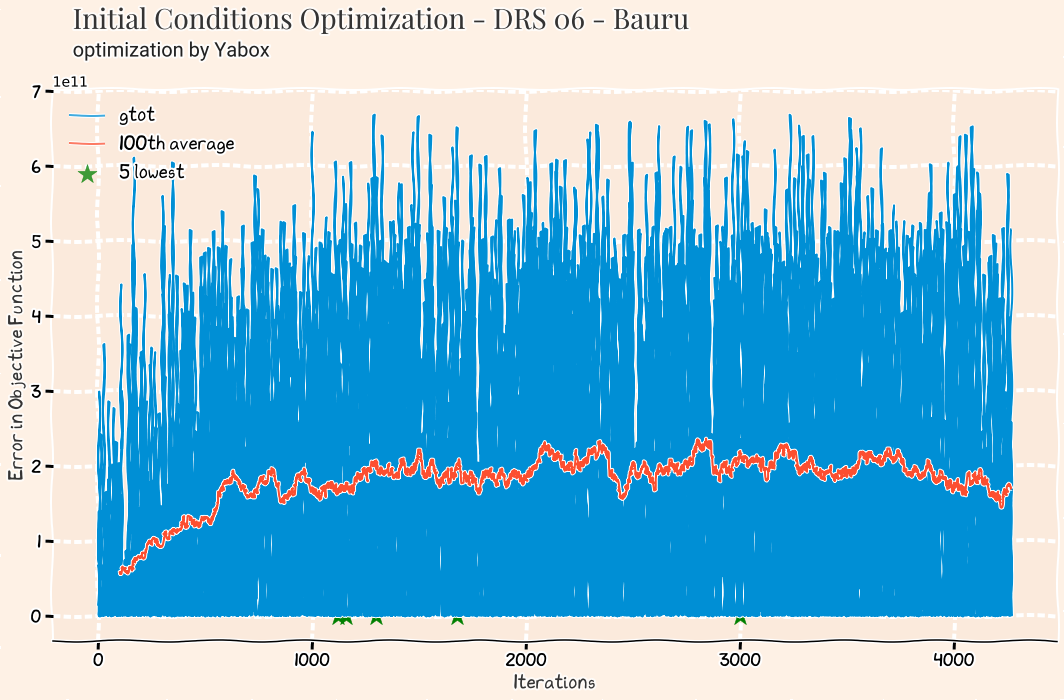

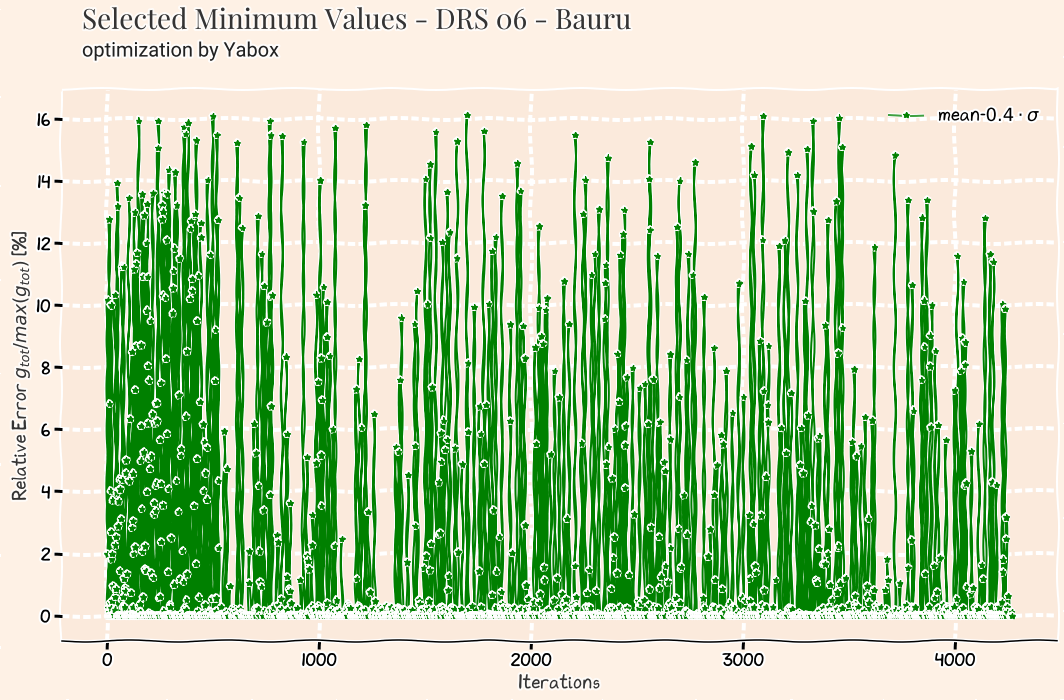

# Results for DRS 07 - Campinas District Region

gtot  startdate  startNcases       s0   i0  d0  wcases    wrec
564  2951833 2020-03-29           20  1865626  602   9  0.5461  0.0282

## 5 Lowest Results

gtot  startdate  startNcases       s0   i0   d0  wcases    wrec
564  2951833 2020-03-29           20  1865626  602    9  0.5461  0.0282
575  3227085 2020-03-30          192  1334168  128  109  0.6112  0.0081
308  3784529 2020-03-29          118  1044307  649    3  0.6279  0.0064
567  5681999 2020-04-03          137   965040  558  139  0.3696  0.0313
230  6674698 2020-03-29           81  1231471  288  149  0.3853  0.0169

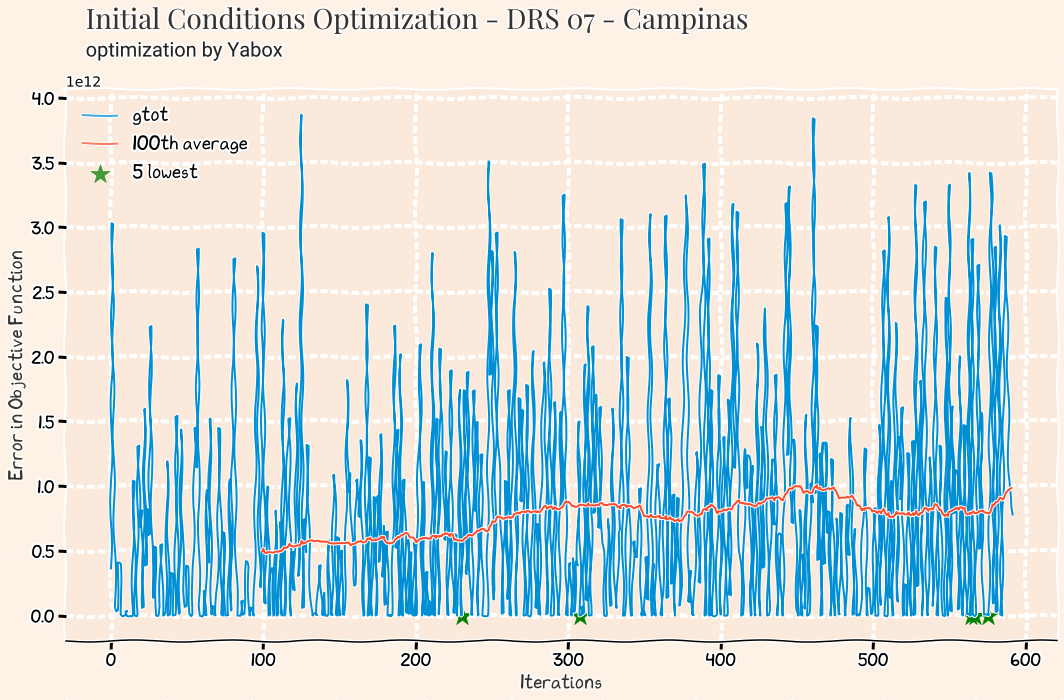

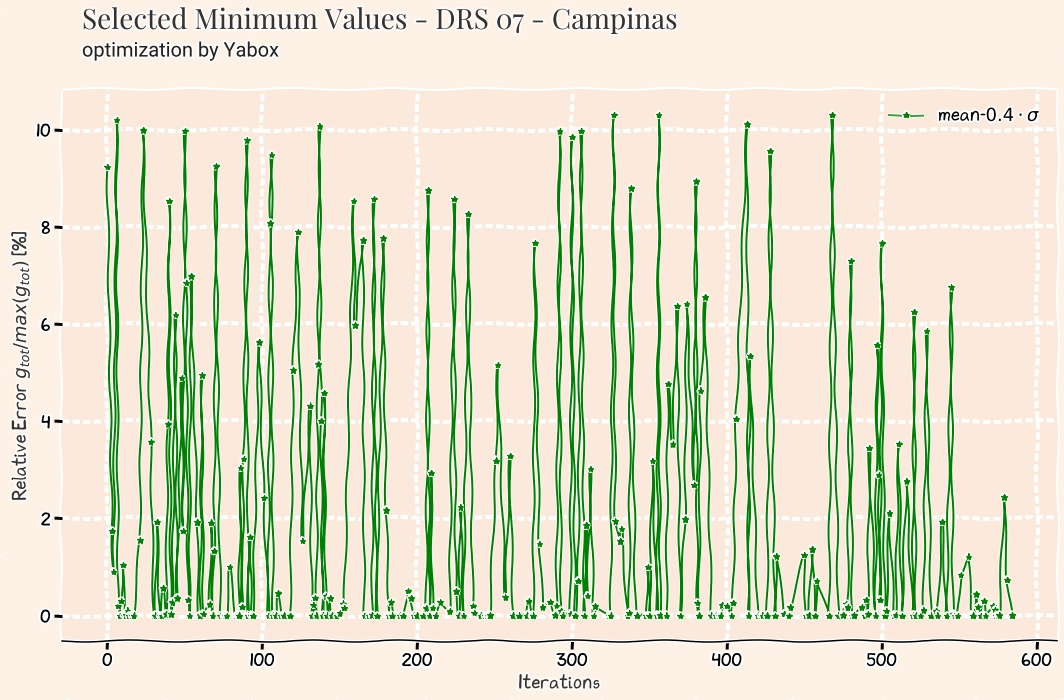

# Results for DRS 08 - Franca District Region

gtot  startdate  startNcases      s0   i0   d0  wcases    wrec
5090  12463 2020-04-01          176  256200  366  230  0.3587  0.0218

## 5 Lowest Results

gtot  startdate  startNcases      s0   i0   d0  wcases    wrec
5090  12463 2020-04-01          176  256200  366  230  0.3587  0.0218
2503  13666 2020-04-01            3  237187   37   26  0.4088  0.0257
1786  15355 2020-03-31           37  269436  106   19  0.6443  0.0285
4534  16984 2020-04-03          230  272010   92  185  0.3760  0.0031
2758  19889 2020-04-02           40  284852  150   20  0.5635  0.0289

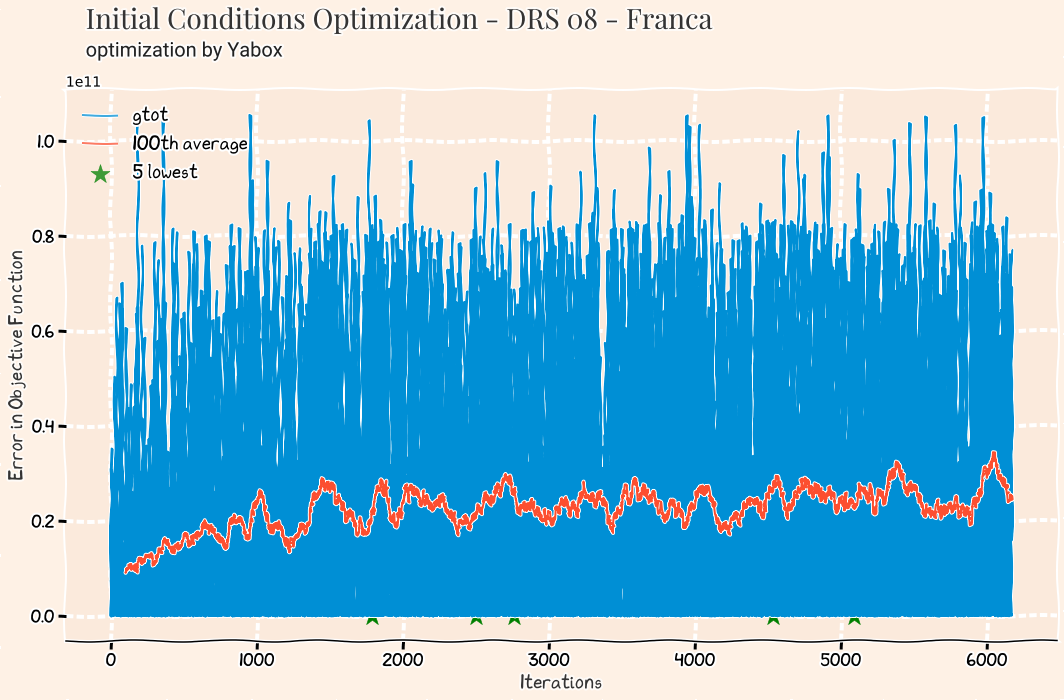

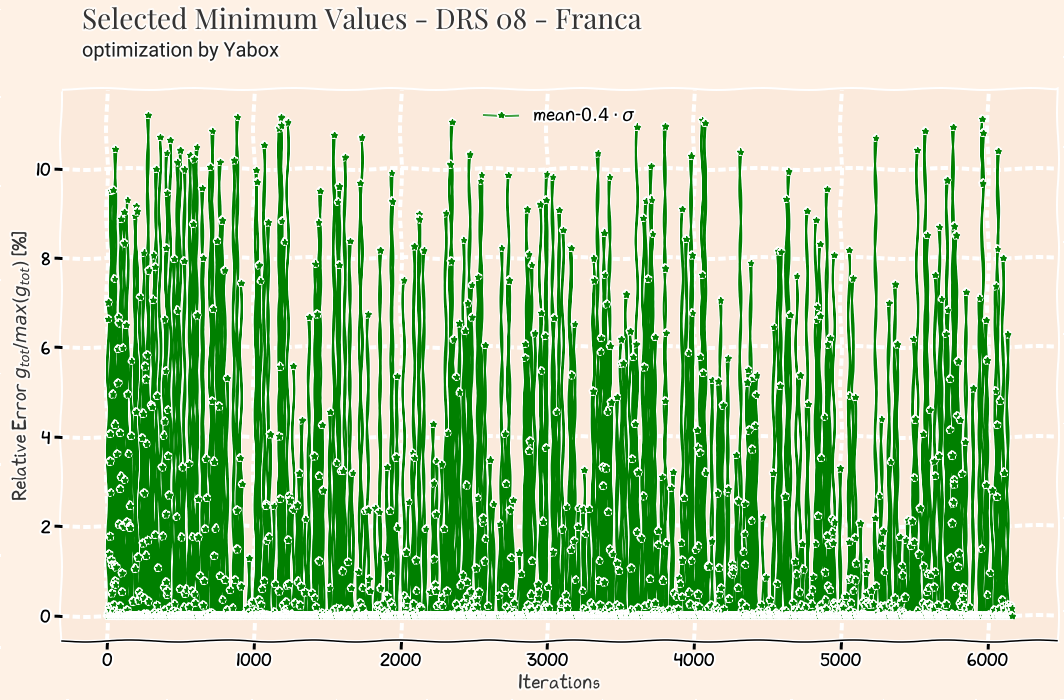

# Results for DRS 09 - Marília District Region

gtot  startdate  startNcases      s0   i0   d0  wcases    wrec
2596  15807 2020-03-30           22  456106  292  241   0.571  0.0187

## 5 Lowest Results

gtot  startdate  startNcases      s0   i0   d0  wcases    wrec
2596  15807 2020-03-30           22  456106  292  241  0.5710  0.0187
1061  52820 2020-04-01           43  403419   76   60  0.4539  0.0175
648   53053 2020-03-29          119  323515  988    1  0.4902  0.0395
2165  53301 2020-04-01          130  405271  136   44  0.6470  0.0149
3831  54059 2020-03-30          220  430505  463    5  0.5371  0.0250

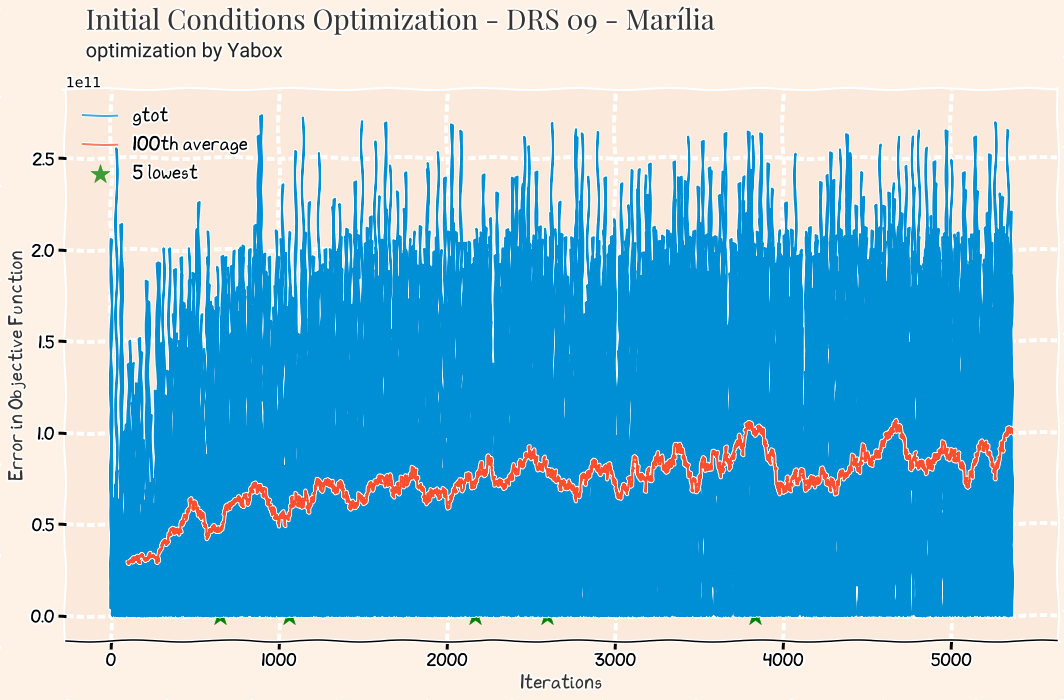

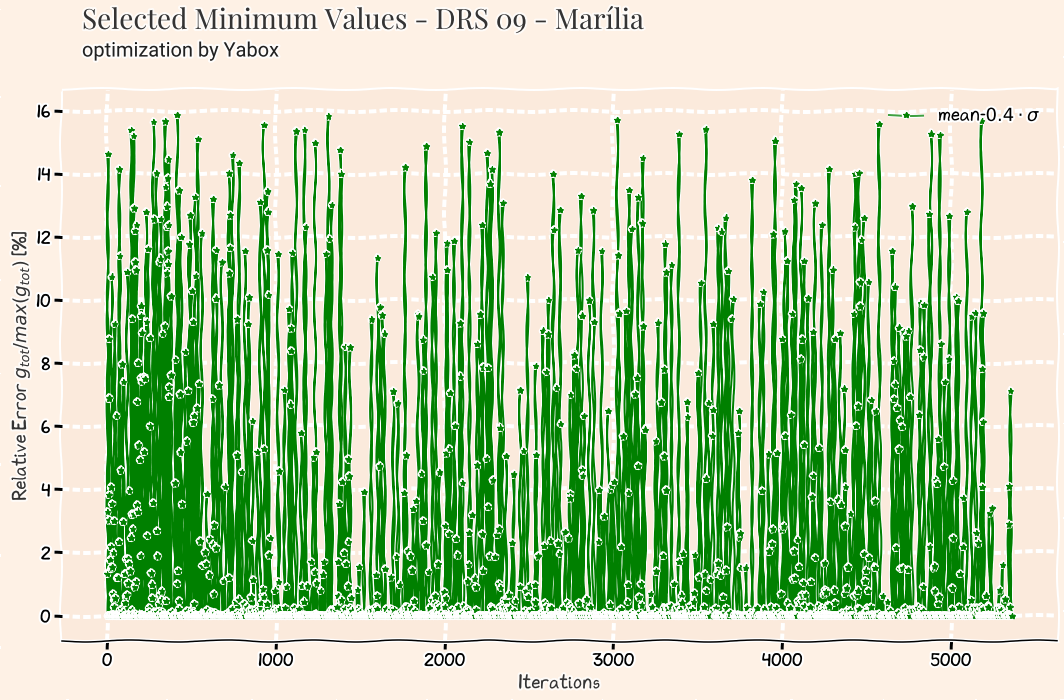

# Results for DRS 10 - Piracicaba District Region

gtot  startdate  startNcases      s0   i0   d0  wcases    wrec
2738  94688 2020-04-02          142  493679  384  119  0.4715  0.0408

## 5 Lowest Results

gtot  startdate  startNcases      s0   i0   d0  wcases    wrec
2738   94688 2020-04-02          142  493679  384  119  0.4715  0.0408
508   167631 2020-04-03          108  491232  586   49  0.6255  0.0320
2576  331632 2020-03-29           31  623552  138   94  0.5995  0.0107
849   357379 2020-04-03          217  502262  232   33  0.6248  0.0188
4262  382964 2020-04-02          189  631176  928  122  0.5129  0.0357

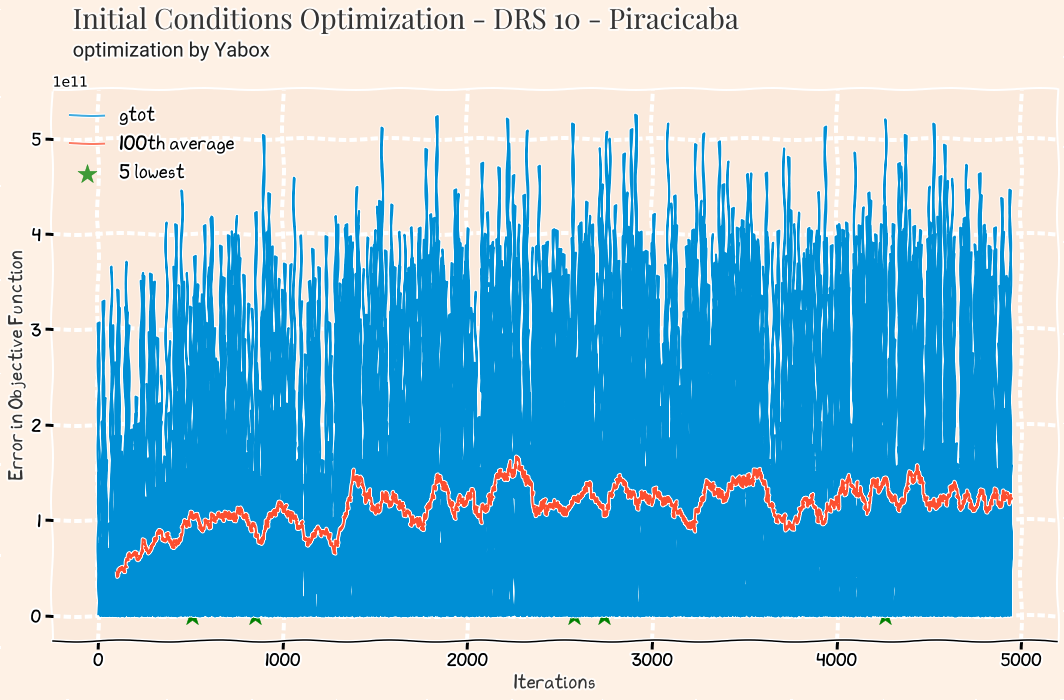

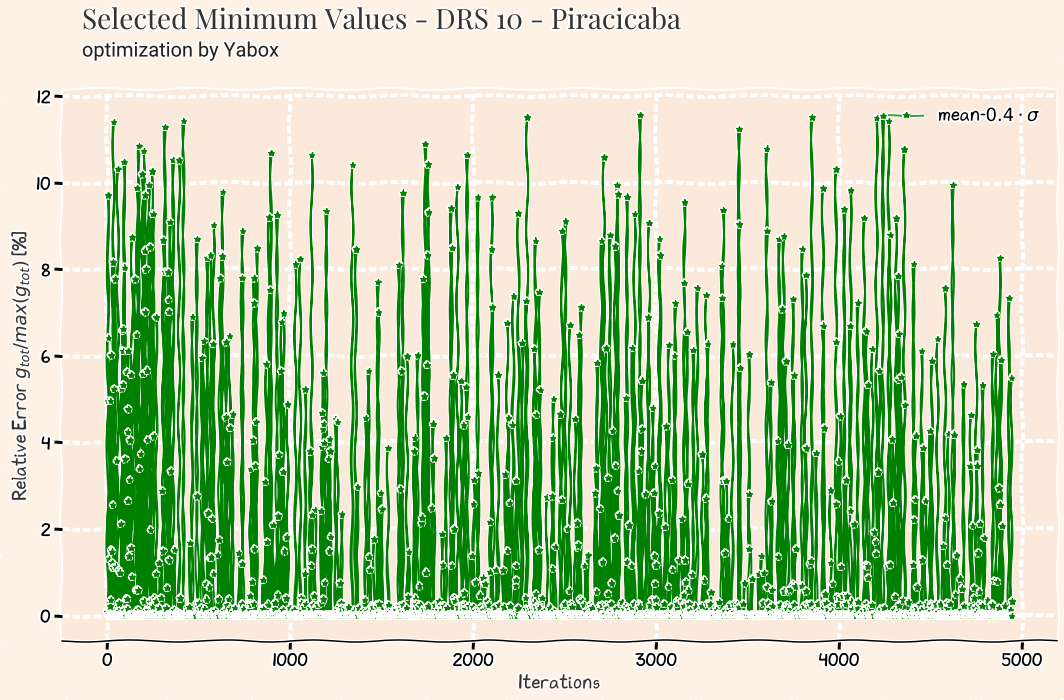

# Results for DRS 11 - Presidente Prudente District Region

gtot  startdate  startNcases      s0   i0  d0  wcases    wrec
3173  4088 2020-03-31           57  112749  713   7  0.4746  0.0153

## 5 Lowest Results

gtot  startdate  startNcases      s0   i0   d0  wcases    wrec
3173   4088 2020-03-31           57  112749  713    7  0.4746  0.0153
1880  14154 2020-04-01           55  308938  353   82  0.5696  0.0477
1133  18056 2020-04-02          193  291752  673  224  0.4944  0.0012
3494  18251 2020-03-30           34  303410  844  219  0.4859  0.0281
1067  19140 2020-03-30            8  301362  202   85  0.4696  0.0450

In [ ]:
ggtot=[]
for districtRegion in DRS:
    versionStr=str(version)
    dateparse = lambda x: datetime.strptime(x, ' %Y-%m-%d')
    histOptAll= pd.read_table('./results/history_'+districtRegion+versionStr+'.csv', sep=",", \
                                index_col=0, header=None, parse_dates=[3], date_parser=dateparse,
        names = ["districtRegion","gtot",\
            "s0","startdate","i0","d0","startNcases","wcases","wrec"])
    histOptAll = histOptAll[['gtot', 'startdate','startNcases','s0',"i0","d0","wcases","wrec"]]
        
    #clean data
    histOptAll=histOptAll.dropna(how='all')
    histOptAll.gtot=pd.to_numeric(histOptAll.gtot, errors='coerce')
    histOptAll = histOptAll.reset_index(drop=True)
    histOptAll = histOptAll[histOptAll.loc[:,"gtot"]<0.5e14]
    
    #format integers and decimal places
    histOptAll['gtot'] = histOptAll['gtot'].apply(lambda x: int(x+0.5))
    histOptAll['d0'] = histOptAll['d0'].apply(lambda x: int(x+0.5))
    histOptAll['startNcases'] = histOptAll['startNcases'].apply(lambda x: int(x+0.5))
    histOptAll['s0'] = histOptAll['s0'].apply(lambda x: int(x+0.5))
    histOptAll['i0'] = histOptAll['i0'].apply(lambda x: int(x+0.5))
    histOptAll['wcases'] = histOptAll['wcases'].apply(lambda x: round(x,4))
    histOptAll['wrec'] = histOptAll['wrec'].apply(lambda x: round(x,4))
    
    #print optimum parameters
    histOpt=histOptAll[histOptAll.gtot==min(histOptAll.gtot)]
    histOpt=histOpt.head(1)
    display(Markdown("# Results for "+districtRegion+" District Region"))
    display(histOpt.iloc[:,0:8])
    histOpt.to_csv("data/vars_optimized_"+districtRegion+model+"HistMin.csv", sep=",", index=False)
        
    #current parameters
    query = dfparam.query('DRS == "{}"'.format(districtRegion)).reset_index()
    parameters = np.array(query.iloc[:, 2:])[0]
    if len(parameters)>12:
        date,predict_range,s0,e0,a0,i0,r0,d0,startNCases,ratio,wcases,wrec,popEst = parameters
    else:
        date,predict_range,s0,e0,a0,i0,r0,d0,startNCases,ratio,wcases,wrec = parameters
    
    #query parameters
    j = query['index'].values[0]
    
    #define s0, i0 and d0
    dfparam.at[j, "s0"] = histOpt.s0
    dfparam['s0'] = dfparam['s0'].astype(int)
    dfparam.at[j, "i0"] = histOpt.i0
    dfparam['i0'] = dfparam['i0'].astype(int)
    dfparam.at[j, "d0"] = histOpt.d0
    dfparam.at[j, "START"] = histOpt.startNcases
    
    dfparam['a0'] = dfparam['a0'].astype(int)
    dfparam['e0'] = dfparam['e0'].astype(int)
    dfparam['r0'] = dfparam['r0'].astype(int)
    dfparam['d0'] = dfparam['d0'].astype(int)
    #define Start N Cases
    dfparam['START'] = dfparam['START'].astype(int)
    #define date, wcases, wrec
    dfparam.at[j, "start-date"] = histOpt.startdate.dt.strftime('%Y-%m-%d').values[0]
    dfparam.at[j, "WCASES"] = histOpt.wcases
    dfparam.at[j, "WREC"] = histOpt.wrec
    
    dfparam.r0=0
    
    #save new parameters
    dfparam.to_csv("data/param_optimized_"+model+"_HistMin.csv", sep=",", index=False)
    
    ggtot.append(histOpt.gtot.values[0])
    
    #prepare plotting
    color_bg = '#FEF1E5'
    # lighter_highlight = '#FAE6E1'
    darker_highlight = '#FBEADC'
    plt.rc('font', size=14)
    
    with plt.xkcd():
        fig, ax = plt.subplots(figsize=(15, 10),facecolor=color_bg)
        ax.patch.set_facecolor(darker_highlight)
        
        #fonts for the thicks
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontproperties(comic_font)
            label.set_fontsize(16) # Size here overrides font_prop
        
        #labels for x and y axis
        plt.xlabel("Iterations", fontproperties=comic_font, alpha = .75)
        plt.ylabel("Error in Objective Function", fontproperties=comic_font, alpha = .75)
        
        # Hide the left, right and top spines
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        #PLOTTING itself
        x=histOptAll.index
        y=histOptAll.gtot
        ax.plot(x,y, label="gtot")
        display(Markdown("## 5 Lowest Results"))
        histMin=histOptAll.nsmallest(5, ['gtot']).sort_values('gtot').iloc[:,0:8]
        display(histMin)

        ax.scatter(histMin.index, histMin.gtot,label="5 lowest",c='green',marker='*',s=400)
        histOptAll.rolling(100).mean()['gtot'].plot(label="100th average")

        # Adding a title and a subtitle
        plt.text(x = 0.02, y = 1.11, s = "Initial Conditions Optimization - "+districtRegion,
                    fontsize = 34, weight = 'bold', alpha = .75,transform=ax.transAxes, 
                    fontproperties=heading_font)
        plt.text(x = 0.02, y = 1.06,
                    s = "optimization by "+model,
                    fontsize = 26, alpha = .85,transform=ax.transAxes, 
                    fontproperties=subtitle_font)
        
        leg=ax.legend(frameon=False,prop=comic_font,fontsize=16)
        for lh in leg.legendHandles: 
            lh.set_alpha(0.75)
        ax.grid(True, linestyle='--', linewidth='2', color='white',alpha=0.1)

        fig.tight_layout()
        strFile ='./results/convergence_'+districtRegion+versionStr+'.png'
        fig.savefig(strFile, facecolor=fig.get_facecolor(), edgecolor=fig.get_edgecolor())
        plt.show()
        
        fig, ax = plt.subplots(figsize=(15, 10),facecolor=color_bg)
        ax.patch.set_facecolor(darker_highlight)
        
        # Hide the left, right and top spines
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        #fonts for the thicks
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontproperties(comic_font)
            label.set_fontsize(16) # Size here overrides font_prop
        
        histMin=histOptAll.iloc[:,0:8]
        histMin.sort_index(inplace=True)
        
        histMin['error']=histMin.gtot/histMin.gtot.max()*100
        x=histMin.index[histMin.error<histMin.error.mean()-0.4*histMin.error.std()]
        y=histMin.error[histMin.error<histMin.error.mean()-0.4*histMin.error.std()]
                
        ax.plot(x, y, label="mean-$0.4 \cdot \sigma$",c='green',marker='*')
        
        #labels for x and y axis
        plt.xlabel("Iterations", fontproperties=comic_font, alpha = .75)
        plt.ylabel("Relative Error $g_{tot}/max(g_{tot})$ [%]", fontproperties=comic_font, alpha = .75)

        # Adding a title and a subtitle
        plt.text(x = 0.02, y = 1.11, s = "Selected Minimum Values - "+districtRegion,
                    fontsize = 34, weight = 'bold', alpha = .75,transform=ax.transAxes, 
                    fontproperties=heading_font)
        plt.text(x = 0.02, y = 1.06,
                    s = "optimization by "+model,
                    fontsize = 26, alpha = .85,transform=ax.transAxes, 
                    fontproperties=subtitle_font)
        
        leg=ax.legend(frameon=False,prop=comic_font,fontsize=16)
        for lh in leg.legendHandles: 
            lh.set_alpha(0.75)
        ax.grid(True, linestyle='--', linewidth='2', color='white',alpha=0.1)

        fig.tight_layout()
        strFile ='./results/minimumPoints_'+districtRegion+versionStr+'.png'
        fig.savefig(strFile, facecolor=fig.get_facecolor(), edgecolor=fig.get_edgecolor())
        plt.show()

In [ ]:
display(Markdown("# Final Results for Initial Conditions"))
display(Markdown("## "+model+" optimization model"))

from IPython.display import HTML

dfparam["gtot"] = pd.Series(ggtot)
dfparam['gtot'] = dfparam['gtot'].astype(int)
dfparam['RATIO'] = dfparam['RATIO'].round(decimals=2)

gtot_min=dfparam.gtot.min()
gtot_max=dfparam.gtot.max()
gtot_range=gtot_max-gtot_min
gtot_mean=dfparam.gtot.mean()
gtot_std=dfparam.gtot.std()

gtot_high=(gtot_mean)/gtot_range
gtot_low=abs(gtot_mean-gtot_std)/gtot_range

s = dfparam.style.background_gradient(cmap='RdYlGn_r',
            axis=0,subset=['s0','i0','d0','gtot'],low=gtot_low/2.74,high=gtot_high/100)
display(s)